In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# the directory where your data is
#PATH_to_data = '/content/drive/My Drive/STROKE_code/MMPOSE/data/patient_output/processed/NIHSS/'
PATH_to_data = '/content/drive/My Drive/'
import os
os.chdir(PATH_to_data)
import sys
sys.path.append(PATH_to_data)

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

import numpy as np
import pandas as pd
# Set the display option to show all columns
pd.set_option('display.max_columns', None)

#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath

# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 500
# the number of features (from the data)
NUMBER_FEATURES = 24 # 22 or 24 if you add shoulders

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Num GPUs Available:  1


In [ ]:
#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath

# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 500
# the number of features (from the data)
NUMBER_FEATURES = 24 # 22 or 24 if you add shoulders

In [ ]:
# SPECIAL CLEANED DATASET
#clean = pd.read_csv('cleaned_merged_stroke2.csv') #short
clean = pd.read_csv('cleaned_slided_stroke2.csv') #long slided
clean.head()

,Unnamed: 0,date,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6,X7,Y7,X8,Y8,X9,Y9,X10,Y10,l_degr,r_degr,day,hour,minute,if_nobody,if_multiple_people,patient_ID,Date of visit,NIHSS,L Motor Arm Score,R Motor Arm Score,L Motor Leg Score,R Motor Leg Score,left-opposite-2,right-opposite-2,left-2,right-2,fragment,l_shoulder,r_shoulder,new_fragment
0,0,2021-02-25 08:03:00,721.64610,187.571300,661.50610,180.48535,770.18270,115.90236,610.07263,184.08115,764.926157,151.742643,604.526414,223.929339,856.758329,180.821920,618.875212,365.228554,881.531196,218.900107,678.567997,386.479011,127.34059,115.394035,20210225,8,3,False,True,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,159.322756,111.197974,0
1,1,2021-02-25 08:03:00,554.56260,96.056640,509.94162,115.88818,584.30994,86.14087,480.19430,140.67761,752.148884,155.759889,601.858466,226.622002,844.162889,188.988036,616.003451,367.843641,872.367358,224.993303,676.468194,377.727612,141.34018,105.003600,20210225,8,3,False,False,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,122.757627,99.516033,0
2,2,2021-02-25 08:03:00,550.64575,93.133820,507.48508,114.71414,583.01636,87.73871,480.50960,136.29453,738.550565,162.262048,595.535127,233.227808,830.029887,204.804058,609.543101,374.601431,862.355175,243.420316,669.931443,377.372595,142.98010,98.286075,20210225,8,3,False,False,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,122.347439,100.392060,0
3,3,2021-02-25 08:03:00,760.14530,167.648560,699.49820,170.96321,748.58630,204.45068,677.13904,212.35374,726.508893,164.685014,591.701948,234.889503,819.358572,209.783454,604.199422,375.832088,853.826304,246.299315,665.522481,370.489994,106.19508,90.088510,20210225,8,3,False,True,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,128.200295,88.757398,0
4,4,2021-02-25 08:03:00,554.59580,94.403564,515.08960,114.15665,584.22546,89.46530,485.46000,138.84805,722.878121,159.803916,585.487526,231.860448,816.644089,208.374901,594.898580,372.783771,854.216839,249.863460,656.507793,367.448240,145.67882,88.870993,20210225,8,3,False,False,BC_09,2021-02-25,3,3,0,0,0,2,0,1,0,5,122.869366,102.298238,0


In [ ]:
# recalculate new fragments
'''
def highlight_fragments(dataframe, allowed_missing_seconds, if_message):
    # allowed_missing_seconds: if a difference between timedate in "time_diff" column for consequent frames is bigger, we consider the next frame to be the new fragment

    dataframe['time_diff'] = abs(dataframe['date'].diff() )
    dataframe['new_fragment']  = (dataframe['time_diff'] >= pd.Timedelta(seconds = allowed_missing_seconds) ).cumsum()
    dataframe = dataframe.drop( columns=['time_diff'] )

    if(if_message):
        print('The number of separated fragments: ', len(dataframe['new_fragment'].unique()))

    return dataframe

# Convert 'date' with data type 'object' to 'datetime' format
clean['date'] = pd.to_datetime(clean['date'])
print("Data type of column 'date':", clean['date'].dtype)
#clean = clean.reset_index(drop=False)
clean = highlight_fragments( clean, 500, if_message=True)

clean[ ['patient_ID','new_fragment'] ].value_counts(normalize=True)
'''

'\ndef highlight_fragments(dataframe, allowed_missing_seconds, if_message):\n    # allowed_missing_seconds: if a difference between timedate in "time_diff" column for consequent frames is bigger, we consider the next frame to be the new fragment\n\n    dataframe[\'time_diff\'] = abs(dataframe[\'date\'].diff() )\n    dataframe[\'new_fragment\']  = (dataframe[\'time_diff\'] >= pd.Timedelta(seconds = allowed_missing_seconds) ).cumsum()\n    dataframe = dataframe.drop( columns=[\'time_diff\'] )\n\n    if(if_message):\n        print(\'The number of separated fragments: \', len(dataframe[\'new_fragment\'].unique()))\n\n    return dataframe\n\n# Convert \'date\' with data type \'object\' to \'datetime\' format\nclean[\'date\'] = pd.to_datetime(clean[\'date\'])\nprint("Data type of column \'date\':", clean[\'date\'].dtype)\n#clean = clean.reset_index(drop=False)\nclean = highlight_fragments( clean, 500, if_message=True)\n\nclean[ [\'patient_ID\',\'new_fragment\'] ].value_counts(normalize=True)

In [ ]:
# Apply sliding window with a step to your data and save it
'''
# Define sliding window size
window_size = NUMBER_TIMESTEPS # =500  # Adjust this as needed
step_size = 100  # Adjust this to the desired step size

# Function to create sliding window indices within a fragment with a step
def sliding_window_indices(df_length):
    return [(i, i + window_size) for i in range(0, df_length - window_size + 1, step_size)]

# Apply sliding window within each fragment
result_indices = []
for _, fragment_df in clean.groupby('new_fragment'):
    indices = sliding_window_indices(len(fragment_df))
    result_indices.extend([(fragment_df.index[start:end]) for start, end in indices])

# Combine the results into a new dataframe
result = clean.loc[pd.Index(np.concatenate(result_indices))]
len(result)

# Save the result as a CSV file
result.to_csv('cleaned_slided_stroke2.csv', index=True)

# Save the result as a .npy file
#np.save('cleaned_slided_stroke.npy', result.to_records(index=True))
'''

# Visualize the sliding window
'''
import matplotlib.pyplot as plt
# Plot the data
for fragment, fragment_df in result.groupby('fragment'):
    plt.figure()
    plt.plot(fragment_df['date'], fragment_df['l_degr'], marker='o')
    plt.title(f'Fragment {fragment} Sliding Windows')
    plt.xlabel('date')
    plt.ylabel('l_degr')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
plt.show()
'''

"\nimport matplotlib.pyplot as plt\n# Plot the data\nfor fragment, fragment_df in result.groupby('fragment'):\n    plt.figure()\n    plt.plot(fragment_df['date'], fragment_df['l_degr'], marker='o')\n    plt.title(f'Fragment {fragment} Sliding Windows')\n    plt.xlabel('date')\n    plt.ylabel('l_degr')\n    plt.xticks(rotation=45)\n    plt.grid(True)\n    plt.tight_layout()\nplt.show()\n"

In [ ]:
len(clean)

348000

In [ ]:
clean['L Motor Arm Score'].value_counts(normalize=True)

4    0.451149
3    0.215517
0    0.193966
2    0.127874
1    0.011494
Name: L Motor Arm Score, dtype: float64

In [ ]:
# Define a custom function to map 'nihss' values to 'left-3'
def map_class(nihss_value):
    if 0 <= nihss_value <= 1:
        return 0
    elif 2 <= nihss_value <= 3:
        return 1
    elif nihss_value == 4:
        return 2
    else:
        return None  # You can handle other cases as needed

# Create the 'left-3' column based on the 'nihss' values
clean['left-3'] =  clean['L Motor Arm Score'].apply(map_class)

In [ ]:
clean['left-3'].value_counts(normalize=True)

2    0.451149
1    0.343391
0    0.205460
Name: left-3, dtype: float64

In [ ]:
# Calculate the number of occurrences of each class in the "new_fragment" column and print them out
fragment_counts = clean['new_fragment'].value_counts()
print( fragment_counts.sort_values() )

38      500
46      500
49      500
45      500
55      500
43      500
53      500
51      500
41     1000
37     1000
42     1000
12     1000
47     1000
31     1500
44     1500
50     1500
6      1500
7      2000
0      2000
56     2000
28     2000
48     2500
34     2500
39     2500
27     3000
36     3000
30     3000
33     3500
52     3500
2      4000
19     4000
29     4000
35     4000
15     4000
57     5000
54     5000
13     5000
32     5500
22     6000
8      6500
25     6500
26     7000
17     7000
20     7500
40     8000
3      8500
10     9500
21    10000
4     10500
1     11500
24    12000
9     13500
18    14000
16    15000
5     15500
14    25000
23    33000
11    34500
Name: new_fragment, dtype: int64


In [ ]:
print ('number of fragments = {}'.format(len(clean['new_fragment'].unique())) )

number of fragments = 58


In [ ]:
#clean[clean['fragment'] == 0]

In [ ]:
# Define a custom function to cut each class to be a multiple of 500
def cut_to_multiple(df, length=500):
    return df.iloc[:len(df) // length * length]

# Group the dataframe by "class" and apply the custom function to each group
clean = clean.groupby('new_fragment').apply(cut_to_multiple).reset_index(drop=True)

<ipython-input-26-822562995597>:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  clean = clean.groupby('new_fragment').apply(cut_to_multiple).reset_index(drop=True)


In [ ]:
print('The new number of separated fragments: ', len(clean['new_fragment'].unique()))

print('The new number of patients: ', len(clean['patient_ID'].unique()))

The new number of separated fragments:  58
The new number of patients:  14


In [ ]:
# Print all unique values in column 'patient_ID'
print(clean['patient_ID'].unique())

['BC_09' 'MS_05' 'MC_22' 'BD_07' 'AC_20' 'DD_18' 'OM_17' 'LC_19' 'PC_06'
 'LH_24' 'IM_38' 'VK_16' 'ND_11' 'RO_26']


In [ ]:
len(clean)

348000

In [ ]:
 #LC_19 та DD-18

# Remove rows where 'b' is equal to 'abc'
#clean = clean[  (clean['patient_ID'] != 'DD_18')  ]# & (clean['patient_ID'] != 'LC_19')]

# Print all unique values in column 'patient_ID'
#print(clean['patient_ID'].unique())

#len(clean)

In [ ]:
clean['left-3'].value_counts(normalize=True)

2    0.451149
1    0.343391
0    0.205460
Name: left-3, dtype: float64

In [ ]:
# Filter rows where 'left-opposite-2' is 0 or 2
#clean = clean[(clean['left-opposite-2'] == 0) | (clean['left-opposite-2'] == 2)]

In [ ]:
# SPECIAL CLEANED DATASET
X = clean[ ['new_fragment', 'date', 'X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5', 'X6', 'Y6', 'X7', 'Y7', 'X8', 'Y8', 'X9', 'Y9', 'X10', 'Y10', 'l_degr', 'r_degr', 'l_shoulder', 'r_shoulder'] ]
Y = clean[ ['new_fragment', 'date', 'NIHSS', 'L Motor Arm Score', 'R Motor Arm Score', 'L Motor Leg Score', 'R Motor Leg Score', 'left-3', 'left-2', 'right-2', 'left-opposite-2', 'right-opposite-2'] ] # - date

print('X=',X.columns.to_list())
print('Y=',Y.columns.to_list())

X= ['new_fragment', 'date', 'X1', 'Y1', 'X2', 'Y2', 'X3', 'Y3', 'X4', 'Y4', 'X5', 'Y5', 'X6', 'Y6', 'X7', 'Y7', 'X8', 'Y8', 'X9', 'Y9', 'X10', 'Y10', 'l_degr', 'r_degr', 'l_shoulder', 'r_shoulder']
Y= ['new_fragment', 'date', 'NIHSS', 'L Motor Arm Score', 'R Motor Arm Score', 'L Motor Leg Score', 'R Motor Leg Score', 'left-3', 'left-2', 'right-2', 'left-opposite-2', 'right-opposite-2']


In [ ]:
# First, we need to create a new column to identify the chunks of 500 rows
X['chunk'] = X.index // 500
Y['chunk'] = Y.index // 500

X['chunk'].unique()

<ipython-input-39-341d0e818f8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['chunk'] = X.index // 500
<ipython-input-39-341d0e818f8f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y['chunk'] = Y.index // 500


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
# how much data will go to the TEST dataset
cur_test_size = 0.3 #30%

''' '''
# Now, we can use the numpy.random.choice function to randomly select chunks for the test set
test_chunks = np.random.choice(X['new_fragment'].unique(), size=int( len(X['new_fragment'].unique())*cur_test_size), replace=False)

# Split the DataFrame into train and test subsets
# We can then use the isin method to create a boolean mask to select the rows for the test set
test_mask = X['new_fragment'].isin(test_chunks)

# Finally, we can use the boolean mask to split the data into train and test sets
X_train = X[~test_mask]
X_test = X[test_mask]

Y_train = Y[~test_mask]
Y_test = Y[test_mask]

print('X Train shape:', X_train.shape)
print('X Test shape:', X_test.shape)

print('Y Train shape:',  Y_train.shape)
print('Y Test shape:',   Y_test.shape)

X Train shape: (264000, 27)
X Test shape: (84000, 27)
Y Train shape: (264000, 13)
Y Test shape: (84000, 13)


In [ ]:
Y_train[ ['left-3', 'L Motor Arm Score'] ].value_counts(normalize=True)

left-3  L Motor Arm Score
2       4                    0.465909
1       3                    0.248106
0       0                    0.172348
1       2                    0.098485
0       1                    0.015152
dtype: float64

In [ ]:
Y_train['left-3'].value_counts(normalize=True)

2    0.465909
1    0.346591
0    0.187500
Name: left-3, dtype: float64

In [ ]:
Y_test[ ['left-3','new_fragment'] ].value_counts(normalize=True)

left-3  new_fragment
2       18              0.166667
        24              0.142857
1       10              0.113095
        3               0.101190
        8               0.077381
0       32              0.065476
        57              0.059524
        35              0.047619
2       15              0.047619
        19              0.047619
0       34              0.029762
1       7               0.023810
0       44              0.017857
1       6               0.017857
0       31              0.017857
        41              0.011905
        42              0.011905
dtype: float64

In [ ]:
Y_test['new_fragment'].value_counts(normalize=False)

18    14000
24    12000
10     9500
3      8500
8      6500
32     5500
57     5000
15     4000
19     4000
35     4000
34     2500
7      2000
6      1500
31     1500
44     1500
41     1000
42     1000
Name: new_fragment, dtype: int64

In [ ]:
Y_test['left-3'].value_counts(normalize=True)

2    0.404762
1    0.333333
0    0.261905
Name: left-3, dtype: float64

In [ ]:
'''
0, 7, 8, 9, 25
'''

'\n0, 7, 8, 9, 25\n'

In [ ]:
Y_test['left-3'].value_counts(normalize=True) #left-2

2    0.404762
1    0.333333
0    0.261905
Name: left-3, dtype: float64

In [ ]:
Y_train['left-3'].value_counts(normalize=True)

2    0.465909
1    0.346591
0    0.187500
Name: left-3, dtype: float64

In [ ]:
# Sort the DataFrame by index
X_test.sort_index(ascending=True, inplace=True)
X_test[['date','chunk']].head(501)

# IT SHOULD BE CONTINUOUS for 500 rows !

,date,chunk
17500,2021-02-14 18:08:00,35
17501,2021-02-14 18:08:00,35
17502,2021-02-14 18:08:00,35
17503,2021-02-14 18:08:00,35
17504,2021-02-14 18:08:00,35
...,...,...
17996,2021-02-14 18:16:00,35
17997,2021-02-14 18:16:00,35
17998,2021-02-14 18:16:00,35
17999,2021-02-14 18:16:00,35


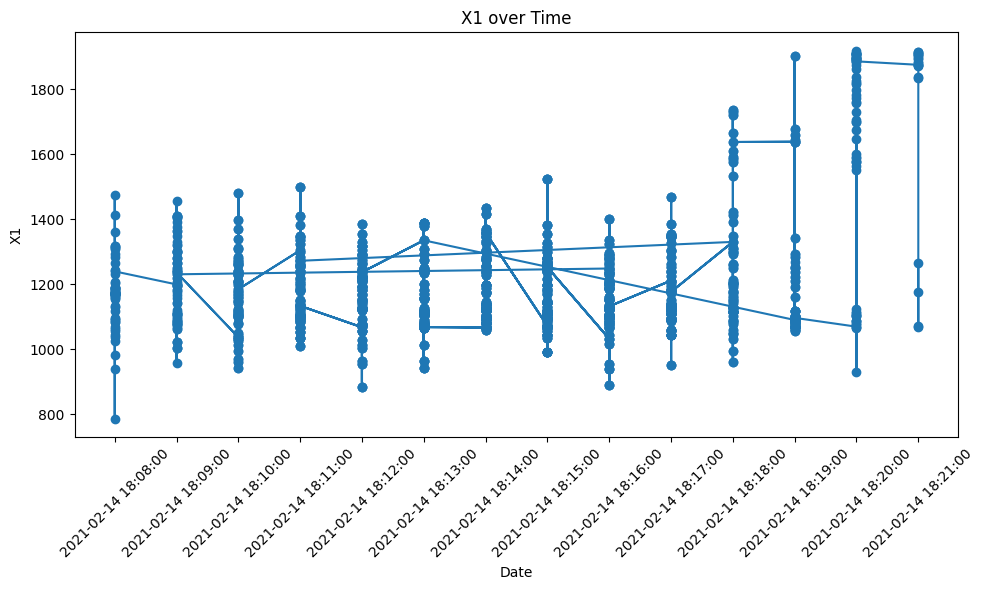

In [ ]:
import matplotlib.pyplot as plt

# Slice the DataFrame to include the first 2000 rows
X_subset = X_test.iloc[0:2000]

# Create a plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(X_subset['date'], X_subset['X1'], marker='o')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('X1')
plt.title('X1 over Time')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()       # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
X_train = X_train.drop(columns=['date','chunk','new_fragment'], axis=1)
X_test  = X_test.drop(columns=['date','chunk','new_fragment'], axis=1)

In [ ]:
print(len(X_test))
print(len(X_train))

84000
264000


In [ ]:
print ('Select every {}th row'.format(NUMBER_TIMESTEPS))

Y_train_short = Y_train[::NUMBER_TIMESTEPS]
Y_test_short  = Y_test[::NUMBER_TIMESTEPS]
print ('Y bunches (train, test):')
print(Y_train_short.shape)
print(Y_test_short.shape)

Select every 500th row
Y bunches (train, test):
(528, 13)
(168, 13)


In [ ]:
Y_train_short = Y_train_short.drop(columns=['date'], axis=1)
Y_test_short  = Y_test_short.drop(columns=['date'], axis=1)

Y_train_short = Y_train_short['left-2'] #2
Y_test_short  = Y_test_short['left-2']

In [ ]:
# count the number of NaN per column
nan_counts = X_train.isna().sum()
print(nan_counts['l_degr'])
print(nan_counts['r_degr'])
print(nan_counts['l_shoulder'])
print(nan_counts['r_shoulder'])

340
90
41
52


In [ ]:
# TRAIN
X_train['l_degr'].fillna(90, inplace=True)
X_train['r_degr'].fillna(90, inplace=True)
X_train['l_shoulder'].fillna(90, inplace=True)
X_train['r_shoulder'].fillna(90, inplace=True)

# TEST
X_test['l_degr'].fillna(90, inplace=True)
X_test['r_degr'].fillna(90, inplace=True)
X_test['l_shoulder'].fillna(90, inplace=True)
X_test['r_shoulder'].fillna(90, inplace=True)

In [ ]:
# count the number of NaN per column
nan_counts = X_train.isna().sum()
print(nan_counts['l_degr'])
print(nan_counts['r_degr'])
print(nan_counts['l_shoulder'])
print(nan_counts['r_shoulder'])

0
0
0
0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Applying Min-Max Scaling to scale the features to the range [0, 1]
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.fit_transform(X_test ), columns=X_test.columns )

X_train.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6,X7,Y7,X8,Y8,X9,Y9,X10,Y10,l_degr,r_degr,l_shoulder,r_shoulder
0,0.414380,0.279363,0.386038,0.253614,0.424908,0.201763,0.356319,0.219283,0.469074,0.157503,0.364450,0.223200,0.494278,0.189618,0.383231,0.321804,0.556851,0.210735,0.433669,0.317840,0.707448,0.641078,0.885126,0.617766
1,0.332941,0.240525,0.311684,0.225599,0.330994,0.188353,0.292157,0.199560,0.461166,0.159459,0.362924,0.224460,0.486999,0.193905,0.381633,0.323120,0.551435,0.213847,0.432427,0.313533,0.785223,0.583353,0.681987,0.552866
2,0.331032,0.239285,0.310479,0.225090,0.330340,0.189073,0.292313,0.197568,0.452749,0.162625,0.359308,0.227549,0.478832,0.202208,0.378038,0.326518,0.545517,0.223258,0.428557,0.313358,0.794334,0.546034,0.679708,0.557733
3,0.433145,0.270908,0.404676,0.249484,0.413996,0.241658,0.389452,0.232131,0.445296,0.163805,0.357116,0.228326,0.472666,0.204823,0.375065,0.327137,0.540475,0.224728,0.425948,0.309970,0.589973,0.500492,0.712224,0.493095
4,0.332957,0.239824,0.314210,0.224848,0.330951,0.189851,0.294758,0.198728,0.443049,0.161428,0.353562,0.226910,0.471097,0.204083,0.369889,0.325604,0.540706,0.226549,0.420612,0.308473,0.809327,0.493728,0.682608,0.568322


In [ ]:
X_train = np.array(X_train)
X_test = np.array(X_test)
print ('X (train, test):')
print(X_train.shape)
print(X_test.shape)

X (train, test):
(264000, 24)
(84000, 24)


In [ ]:
print('2 classes:')
NUMBER_BATCH_TRAIN = X_train.shape[0] // NUMBER_TIMESTEPS
print('X_train = ', X_train.shape)
print('NUMBER_BATCH_TRAIN = ',NUMBER_BATCH_TRAIN)
X_train = np.reshape(X_train, (NUMBER_BATCH_TRAIN, NUMBER_TIMESTEPS, NUMBER_FEATURES))
print('X_train = ', X_train.shape)

NUMBER_BATCH_TEST = X_test.shape[0] // NUMBER_TIMESTEPS
print('X_test = ', X_test.shape)
print('NUMBER_BATCH_TEST = ',NUMBER_BATCH_TEST)
X_test = np.reshape(X_test, (NUMBER_BATCH_TEST, NUMBER_TIMESTEPS, NUMBER_FEATURES))

print('X_test = ', X_test.shape)

2 classes:
X_train =  (264000, 24)
NUMBER_BATCH_TRAIN =  528
X_train =  (528, 500, 24)
X_test =  (84000, 24)
NUMBER_BATCH_TEST =  168
X_test =  (168, 500, 24)


In [ ]:
!pip install keras-tcn

In [ ]:
X_train.shape[0]

411

In [ ]:
from tcn import TCN
from keras.regularizers import l1,l2
from tensorflow import keras
from tensorflow.keras.optimizers.schedules import ExponentialDecay

epochs = 20

lr=0.002 #initial
final_lr = 0.000001
decay_rate = 0.00000000005

steps_per_epoch = NUMBER_BATCH_TRAIN #int(X_train.shape[0] // NUMBER_TIMESTEPS)
learn_rate_decay_factor = (final_lr / lr)**(1/epochs)

lr_schedule = ExponentialDecay(
    initial_learning_rate = lr,
    decay_steps           = steps_per_epoch, #100000
    decay_rate            = learn_rate_decay_factor, #0.96
    staircase=True)

print ('Steps per epoch = {}'.format(steps_per_epoch) )
print ('Learning rate decay factor = {}'.format(learn_rate_decay_factor) )

def build_model(NUMBER_OUTPUTS, NUMBER_FEATURES):
    model = models.Sequential()
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.

    # 1st LSTM layer
    #model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    #model.add(layers.Dropout(0.2))

    # 2nd LSTM layer
    #model.add(layers.LSTM(512, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    #model.add(layers.Dropout(0.2))

    model.add(TCN(512, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES), kernel_size=3, nb_stacks=1, dilations=[1, 2, 4, 8, 16, 32, 64, 128]  ) )

    # Hidden fully connected layers of the neural network
    # l1 or l2
    model.add(layers.Dense(256,activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512,activation='relu', kernel_regularizer=l2(0.001)) )
    model.add(layers.Dropout(0.3)) #0.2 or 0.5
    model.add(layers.Dense(256,activation='relu', kernel_regularizer=l1(0.01)) )
    model.add(layers.Dropout(0.3)) #0.2 or 0.5

    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='sigmoid')) #softmax=multiple sigmoid=2

    opt = Adam(amsgrad=True, learning_rate=lr_schedule) #learning_rate=learn_rate)#, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','Precision','Recall' ]) # categorical_crossentropy #,'accuracy', 'Precision','Recall'

    # this shows the network structure
    model.summary()

    return model


Steps per epoch = 411
Learning rate decay factor = 0.6838305520458344


In [ ]:
# creating the model
model = build_model(NUMBER_OUTPUTS=1, NUMBER_FEATURES=NUMBER_FEATURES)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_2 (TCN)                 (None, 512)               11854336  
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_8 (Dropout)         (None, 256)              

In [ ]:
'''
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate decay function
def lr_decay(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * decay_rate ^ (epoch / decay_steps)

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)
'''

'\nfrom tensorflow.keras.callbacks import LearningRateScheduler\n\n# Define the learning rate decay function\ndef lr_decay(epoch, lr):\n  if epoch < 10:\n    return lr\n  else:\n    return lr * decay_rate ^ (epoch / decay_steps)\n\n# Create a LearningRateScheduler callback\nlr_scheduler = LearningRateScheduler(lr_decay)\n'

In [ ]:
# training the model

# fit model
history = model.fit( X_train, Y_train_short, validation_data=(X_test, Y_test_short), epochs=epochs, batch_size = 64) #, callbacks=[lr_scheduler])

Epoch 1/20
7/7 [==============================] - 17s 1s/step - loss: 224.7755 - accuracy: 0.5231 - precision: 0.5559 - recall: 0.7532 - val_loss: 56.9010 - val_accuracy: 0.2674 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
7/7 [==============================] - 6s 871ms/step - loss: 54.7414 - accuracy: 0.5450 - precision: 0.5769 - recall: 0.7143 - val_loss: 52.4142 - val_accuracy: 0.2674 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
7/7 [==============================] - 7s 952ms/step - loss: 51.0465 - accuracy: 0.5353 - precision: 0.5654 - recall: 0.7489 - val_loss: 49.3675 - val_accuracy: 0.2674 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
7/7 [==============================] - 6s 879ms/step - loss: 47.9737 - accuracy: 0.5085 - precision: 0.5573 - recall: 0.6104 - val_loss: 46.1337 - val_accuracy: 0.7326 - val_precision: 0.7326 - val_recall: 1.0000
Epoch 5/20
7/7 [==============================] - 6s 869ms/step - loss: 45.1164 -

In [ ]:
'''
# Save the entire model (architecture, optimizer state, and weights)
model.save('trained_model.h5')

# Alternatively, you can save just the weights
model.save_weights('model_weights.h5')

from tensorflow.keras.saving import load_model
# Load the entire model from the .h5 file
loaded_model = load_model('trained_model.h5')
'''


'''
# Calling `save('my_model.keras')` creates a zip archive `my_model.keras`.
model.save("stroke_nihss_1.keras")

# It can be used to reconstruct the model identically.
loaded_model = keras.models.load_model("stroke_nihss_1.keras")

# Summary of the loaded model
loaded_model.summary()
'''

'\n# Calling `save(\'my_model.keras\')` creates a zip archive `my_model.keras`.\nmodel.save("stroke_nihss_1.keras")\n\n# It can be used to reconstruct the model identically.\nloaded_model = keras.models.load_model("stroke_nihss_1.keras")\n\n# Summary of the loaded model\nloaded_model.summary()\n'

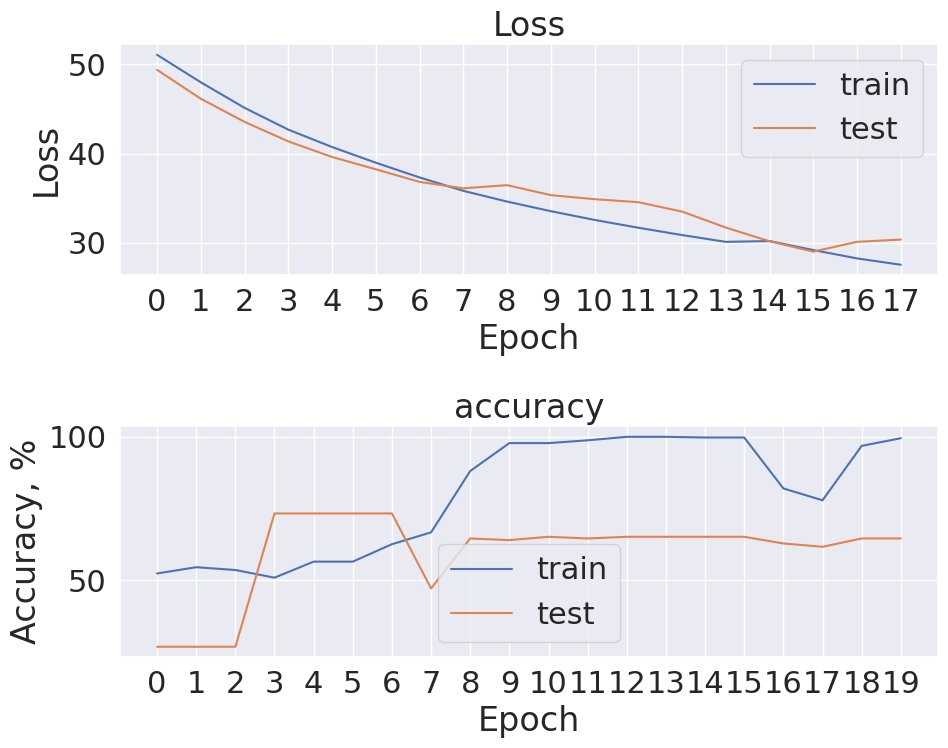

In [ ]:
from matplotlib import pyplot as plt

# Create a larger figure
plt.figure(figsize=(10, 8))

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'][2:], label='train')
plt.plot(history.history['val_loss'][2:], label='test')
plt.legend()
plt.xticks(range(len(history.history['loss'][2:])))
plt.xlabel('Epoch')
plt.ylabel('Loss')

# plot accuracy during training
plt.subplot(212)
plt.title('accuracy')
#plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.plot([acc * 100 for acc in history.history['accuracy']], label='train')
plt.plot([acc * 100 for acc in history.history['val_accuracy']], label='test')
plt.xticks(range(len(history.history['accuracy'])))
plt.xlabel('Epoch')
plt.ylabel('Accuracy, %')

# Adjust spacing between subplots
plt.tight_layout()
plt.legend()

# Save the figure as an image file
plt.savefig('training_results.png')

plt.show()

13/13 [==============================] - 2s 138ms/step


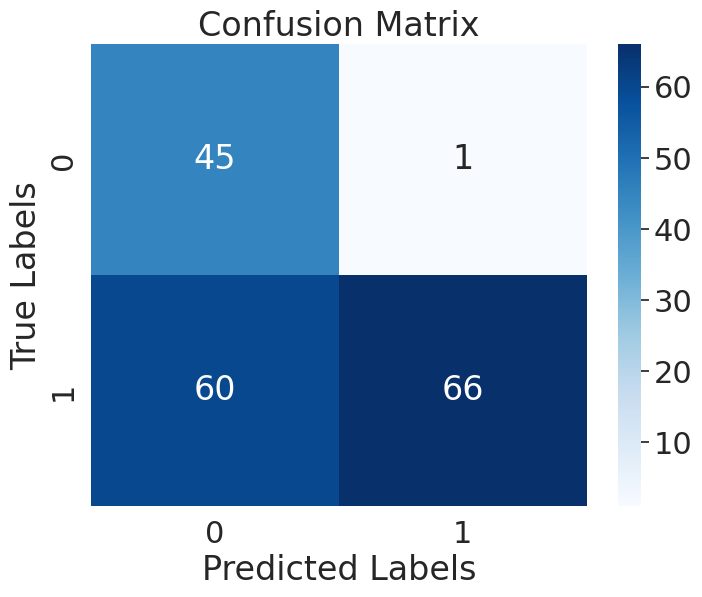

In [ ]:
#NEW CODE# Step 1: Make Predictions# Step 2: Convert Probabilities to Classes using a threshold (e.g., 0.5)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_pred_prob_test = model.predict(X_test)
threshold = 0.5
Y_test_model = (y_pred_prob_test > threshold).astype(int)

y_pred_prob_train = model.predict(X_train)
threshold = 0.5
Y_train_model = (y_pred_prob_train > threshold).astype(int)

# Step 3: Calculate Confusion Matrix
conf_matrix = confusion_matrix(Y_test_short, Y_test_model)

# Step 4: Visualize Confusion Matrix (Optional)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
# Predict outputs and save them in a variable
'''Y_train_model = model.predict(X_train)
Y_test_model = model.predict(X_test)'''


'Y_train_model = model.predict(X_train)\nY_test_model = model.predict(X_test)'

In [ ]:
#Y_train_model

In [ ]:

# Cast the float array to an integer array
# Create a pandas Series from the array
'''y_pred = (Y_train_model > threshold).astype(int)
y_pred = (Y_test_model > threshold).astype(int)
Y_train_model = pd.Series(Y_train_model.astype(int).flatten())
Y_test_model  = pd.Series(Y_test_model.astype(int).flatten())'''

'y_pred = (Y_train_model > threshold).astype(int)\ny_pred = (Y_test_model > threshold).astype(int)\nY_train_model = pd.Series(Y_train_model.astype(int).flatten())\nY_test_model  = pd.Series(Y_test_model.astype(int).flatten())'

In [ ]:
Y_train_model

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

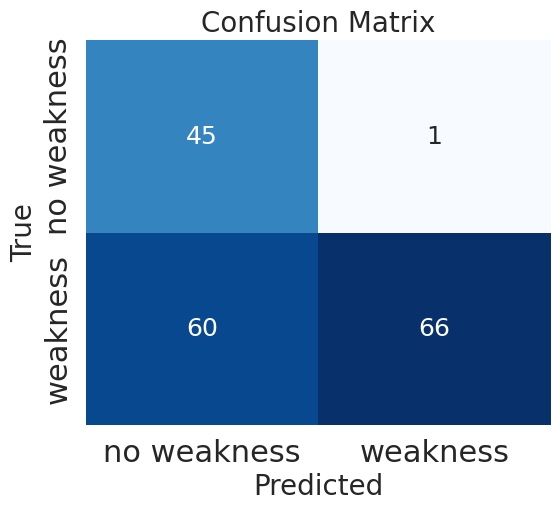

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Sample predicted and true values
#predicted = np.array([1, 0, 1, 1, 0, 1, 0, 1, 0, 1])
#true = np.array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1])

predicted = Y_test_model
true      = Y_test_short

# Calculate confusion matrix
cm = confusion_matrix(true, predicted)
#cm = [[453629,246371],[165458,284674]]

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 5))
#sns.heatmap(cm, annot=True,  cmap="Blues", xticklabels=["minor", "moderate"], yticklabels=["minor", "moderate"]) #fmt="d",

sns.set(font_scale = 2)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["no weakness", "weakness"], yticklabels=["no weakness", "weakness"], cbar=False, annot_kws={"size": 18}) #fmt="d",
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.title('Confusion Matrix', fontsize=20)


# Save the figure as an image file
plt.savefig('confusion_matrix.png')

plt.show()

In [ ]:
Y_train_model = pd.Series(Y_train_model.astype(int).flatten())
Y_test_model  = pd.Series(Y_test_model.astype(int).flatten())

In [ ]:
Y_train_model.value_counts(normalize=False)

1    231
0    180
dtype: int64

In [ ]:
Y_test_model.value_counts(normalize=False)

0    105
1     67
dtype: int64

In [ ]:
Y_train_short.value_counts(normalize=False)

1    231
0    180
Name: left-2, dtype: int64

In [ ]:
Y_test_short.value_counts(normalize=False)

1    126
0     46
Name: left-2, dtype: int64

In [ ]:
print(history.history)

{'loss': [224.77549743652344, 54.74135208129883, 51.046485900878906, 47.97366714477539, 45.116363525390625, 42.678001403808594, 40.73454284667969, 38.978668212890625, 37.332149505615234, 35.83259963989258, 34.633277893066406, 33.55807113647461, 32.57917404174805, 31.705747604370117, 30.887136459350586, 30.126245498657227, 30.21541404724121, 29.209442138671875, 28.273630142211914, 27.56501007080078], 'accuracy': [0.5231143832206726, 0.5450121760368347, 0.5352798104286194, 0.5085158348083496, 0.5644769072532654, 0.5644769072532654, 0.6253041625022888, 0.6666666865348816, 0.8807786107063293, 0.9781022071838379, 0.9781022071838379, 0.9878345727920532, 1.0, 1.0, 0.9975669384002686, 0.9975669384002686, 0.8199513554573059, 0.7785888314247131, 0.9683698415756226, 0.9951338171958923], 'precision': [0.5559105277061462, 0.5769230723381042, 0.5653594732284546, 0.5573122501373291, 0.5751445293426514, 0.5773809552192688, 0.6032171845436096, 0.6284152865409851, 0.8446969985961914, 0.9826086759567261,

6/6 [==============================] - 1s 136ms/step


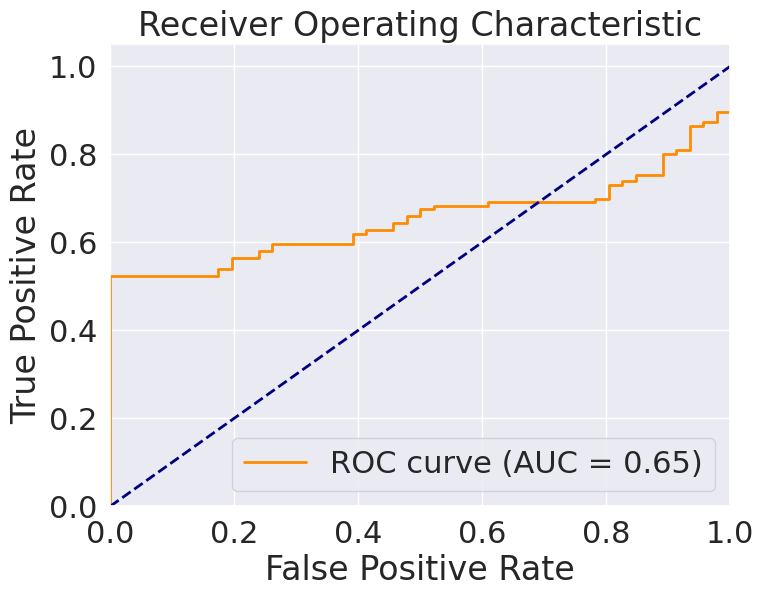

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Make Predictions
y_pred_prob = model.predict(X_test)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test_short, y_pred_prob)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()